# Analysis on correlation between earthquakes and surface mass loading in individual mascons

In [1]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# from global_land_mask import globe
import scipy.stats as stats
import os
import importlib
import geopandas as gpd
# from tqdm import tqdm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.cm as cm
import numpy.ma as ma

# file containing functions:
import loadquakes
importlib.reload(loadquakes)

<module 'loadquakes' from '/Users/amandasyamsul/SLIQ/loadquakes.py'>

In [2]:
# import sys
# !{sys.executable} -m pip install netcdf4

## 1. Load datasets

- GRACE and GRACE-FO
- USGS earthquake catalog with ETAS probabilities

In [3]:
# GRACE data
ds = xr.open_dataset("GRCTellus.JPL.200204_202201.GLO.RL06M.MSCNv02CRI.nc")

# Catalog of events from 2002-04-16 to 2022-1-16 with magnitude >= 5.4
catalog = pd.read_csv('ind_and_bg_probs.csv')
catalog["time"] = catalog["time"].astype("datetime64[ns]")

In [4]:
# This is the catalog with all details from the USGS Earthquake Catalog

original_catalog = pd.read_csv('19970101-20220116.csv')
original_catalog = original_catalog[original_catalog['time']>'2002-04-16']
original_catalog = original_catalog[original_catalog['time']<'2022-01-16']
cat = original_catalog.reset_index()

In [42]:
catalog

,Unnamed: 0.1,Unnamed: 0,target_id,latitude,longitude,time,magnitude,geometry,mc_current,mc_current_above_ref,mu,P_triggered,P_background,zeta_plus_1,depth,dmass
0,0,0,2,-55.5113,-128.4388,2022-01-15 18:23:04.127,5.7,POINT (-55.5113 -128.4388),5.4,0.0,6.907373e-11,0.998822,1.178415e-03,1.0,10.00,4.971506
1,1,1,3,-20.5460,-175.3900,2022-01-15 04:14:45.000,5.8,POINT (-20.546 -175.39),5.4,0.0,6.907373e-11,0.998325,1.674875e-03,1.0,0.00,2.485465
2,2,2,4,-7.0422,105.2063,2022-01-14 09:49:20.820,5.4,POINT (-7.0422 105.2063),5.4,0.0,6.907373e-11,0.999999,6.002016e-07,1.0,34.46,0.527750
3,3,3,5,-6.8600,105.2887,2022-01-14 09:05:41.461,6.6,POINT (-6.86 105.2887),5.4,0.0,6.907373e-11,0.996362,3.637987e-03,1.0,33.00,0.527750
4,4,4,6,-6.6002,147.3665,2022-01-12 13:16:21.730,5.6,POINT (-6.6002 147.3665),5.4,0.0,6.907373e-11,0.998980,1.020001e-03,1.0,80.00,2.113894
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12568,12568,12568,12570,-16.3820,173.2590,2002-04-20 15:59:57.860,6.0,POINT (-16.382 173.259),5.4,0.0,6.907373e-11,0.981736,1.826392e-02,1.0,33.00,-1.649923
12569,12569,12569,12571,17.2330,-101.2500,2002-04-18 17:57:27.700,5.9,POINT (17.233 -101.25),5.4,0.0,6.907373e-11,0.999974,2.606205e-05,1.0,33.00,-2.669669
12570,12570,12570,12572,-27.5350,-70.5860,2002-04-18 16:08:36.780,6.7,POINT (-27.535 -70.586),5.4,0.0,6.907373e-11,0.978985,2.101521e-02,1.0,62.00,-1.934300
12571,12571,12571,12573,-60.6570,-25.8430,2002-04-18 14:17:23.940,5.8,POINT (-60.657 -25.843),5.4,0.0,6.907373e-11,0.999386,6.138115e-04,1.0,10.00,-2.905380


In [5]:
depth = cat['depth']
catalog['depth'] = depth

## 2. Using Mizrahi's ETAS code, filter events that that have less than 90% chance of being triggered
##### The mean probability of being triggered (P_triggered) for the catalog is 97.97% with a standard deviation of 9.25% . Here, we examine events that have less 90% probability of being triggered by another earthquake

In [6]:
etas_declustered = catalog[catalog['P_triggered']<.9]

## 3. Add surface load data to the earthquake dataframes

In [7]:
etas_declustered = pd.read_csv('etas_declustered.csv')
catalog = pd.read_csv('catalog.csv')

## 4. Analyze correlation between all events and surface mass loading by mascon

### What we previously did:

Conditional probability for each event is the P(L|E) divided by P(L). The L|E are the loads at the times of an earthquake, while L are the loads at all times globally. 

`def get_cond_probability(all_time_periods, earthquake_only, loads, method):`
    
    cp,bins = calculate_bayes(earthquake_only,all_time_periods,method)

    cp_for_each_event = []
    
    for load in loads:
        
        this_bin = bins[0]
        i = 0
        while this_bin < load:
            if i == len(cp):
                break
            else:
                i = i + 1
                this_bin = bins[i]
        cp_for_each_event.append(cp[i-1])
        
    return np.array(cp_for_each_event)
    

`def calculate_bayes(earthquake_only,all_time_periods,method):`

    bins = calculate_bin_sizes(earthquake_only,method)

    LgE = np.histogram(earthquake_only, bins=bins, density = True)[0]
    L   = np.histogram(all_time_periods,bins=bins, density = True)[0]
    cp = LgE/L

    return cp, bins


###  This method calculates LgE and L by mascon.

In [8]:
mascon = xr.open_dataset('JPL_MSCNv03_PLACEMENT.nc')

In [9]:
# def calculate_probabilities_by_mascon(all_time_periods, earthquake_only, ds):
    
#     lat_bounds = ds['lat_bounds'].data
#     lon_bounds = ds['lon_bounds'].data
    
#     LgE_list = []
#     L_list = []

#     for lat_idx in range(len(lat_bounds)):
#         for lon_idx in range(len(lon_bounds)):
            
#             lat_min, lat_max = lat_bounds[lat_idx]
#             lon_min, lon_max = lon_bounds[lon_idx]

#             # Find all earthquakes that fall within the current mascon bounds
#             earthquakes_in_mascon = earthquake_only[
#                 (earthquake_only['latitude'] >= lat_min) &
#                 (earthquake_only['latitude'] <= lat_max) &
#                 (earthquake_only['longitude'] >= lon_min) &
#                 (earthquake_only['longitude'] <= lon_max)
#             ]
            
#             if len(earthquakes_in_mascon) > 0:
#                 LgE_for_each = earthquakes_in_mascon['dmass'].tolist()
#             else:
#                 continue  # Skip this mascon if no earthquakes are found

#             # Extract load data (L) for the current mascon (all time periods)
#             lwe_grid = all_time_periods.isel(lat=lat_idx, lon=lon_idx).data.flatten()
            
#             LgE_list.append(LgE_for_each)  # P(L|E) for each mascon
#             L_list.append(lwe_grid)  # P(L) for each mascon

#     return LgE_list, L_list

In [43]:
mascon

<xarray.Dataset>
Dimensions:      (mascon_id: 4551, mascon_lon: 4551, mascon_lat: 4551,
                  mascon_rad: 4551, mascon_elev: 4551)
Coordinates:
  * mascon_id    (mascon_id) float64 1.0 2.0 3.0 ... 4.55e+03 4.551e+03
  * mascon_lon   (mascon_lon) float64 0.0 36.0 108.0 180.0 ... 252.0 324.0 0.0
  * mascon_lat   (mascon_lat) float64 90.0 87.0 87.0 87.0 ... -87.0 -87.0 -90.0
  * mascon_rad   (mascon_rad) float64 167.0 167.0 167.0 ... 167.0 167.0 167.0
  * mascon_elev  (mascon_elev) float64 6.357e+03 6.357e+03 ... 6.357e+03
Data variables:
    *empty*
Attributes:
    Conventions:               CF-1.5
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    standard_name_vocabulary:  CF-1.5
    title:                     mascon_placement
    summary:                   Information on the location of each mascon in ...
    filename:                  NETCDF/RL06p1Mv03/JPL_MSCNv03_PLACEMENT.nc
    variable:                  mascon_placement
    institution:               JPL
    creator_name:              David Wiese
    creator_email:             david.n.wiese@jpl.nasa.gov
    project:                   GRACE
    DATE_CREATED:              14-Oct-2022 13:14:27

In [25]:
def calculate_probabilities_by_mascon(all_time_periods, earthquake_only, mascon_placement):
    
    mascon_center_lat = mascon_placement['mascon_lat'].data
    mascon_center_lon = mascon_placement['mascon_lon'].data
    mascon_id = mascon_placement['mascon_id'].data
    
    all_latitudes = all_time_periods['lat'].data
    all_longitudes = all_time_periods['lon'].data
    
    LgE_list = []
    L_list = []
    E_list = []
    N_per_mascon = []
    earthquake_count = 0
    
    mascon_area_km2 = 3 * 111 * 3 * 111  # Approximate area of a 3° by 3° mascon in km²

    for i in range(len(mascon_id)):
            # Define approximate bounds based on a 3-degree mascon size (1.5 degrees around center)
            lat_min = mascon_center_lat[i] - 1.5
            lat_max = mascon_center_lat[i] + 1.5
            lon_min = mascon_center_lon[i] - 1.5
            lon_max = mascon_center_lon[i] + 1.5

            # Find all earthquakes that fall within the current mascon bounds
            earthquakes_in_mascon = earthquake_only[
                (earthquake_only['latitude'] >= lat_min) &
                (earthquake_only['latitude'] <= lat_max) &
                (earthquake_only['longitude'] >= lon_min) &
                (earthquake_only['longitude'] <= lon_max)
            ]
            
            if len(earthquakes_in_mascon) > 0:
                dmass_values = earthquakes_in_mascon['dmass']
                N_per_mascon = len(earthquakes_in_mascon)  # Earthquakes for the current mascon
                PE = N_per_mascon / mascon_area_km2  # Calculate PE for the current mascon

                for dmass in dmass_values:
                    LgE_list.append(dmass)

                    # Find the lat/lon indices for the load data
                    lat_indices = np.where((all_latitudes >= lat_min) & (all_latitudes <= lat_max))[0]
                    lon_indices = np.where((all_longitudes >= lon_min) & (all_longitudes <= lon_max))[0]

                    lwe_grid = all_time_periods.isel(lat=lat_indices, lon=lon_indices).data.flatten()

                    L_list.append(lwe_grid)
                    earthquake_count += 1

                    # Append PE for this particular earthquake event
                    E_list.append(PE)

                print(f"Mascon {mascon_id[i]}: {len(earthquakes_in_mascon)} earthquake(s)")
    
    print(f"Total number of earthquakes appended: {earthquake_count}")
    return LgE_list, L_list, E_list, N_per_mascon

LgE_list, L_list, E_list, N_per_mascon = calculate_probabilities_by_mascon(ds['lwe_thickness'], etas_declustered, mascon)

Mascon 37.0: 2 earthquake(s)
Mascon 61.0: 1 earthquake(s)
Mascon 145.0: 1 earthquake(s)
Mascon 190.0: 1 earthquake(s)
Mascon 244.0: 1 earthquake(s)
Mascon 352.0: 1 earthquake(s)
Mascon 413.0: 1 earthquake(s)
Mascon 485.0: 1 earthquake(s)
Mascon 487.0: 1 earthquake(s)
Mascon 488.0: 1 earthquake(s)
Mascon 489.0: 1 earthquake(s)
Mascon 496.0: 2 earthquake(s)
Mascon 497.0: 2 earthquake(s)
Mascon 573.0: 1 earthquake(s)
Mascon 624.0: 2 earthquake(s)
Mascon 625.0: 1 earthquake(s)
Mascon 626.0: 1 earthquake(s)
Mascon 630.0: 1 earthquake(s)
Mascon 640.0: 1 earthquake(s)
Mascon 641.0: 2 earthquake(s)
Mascon 644.0: 1 earthquake(s)
Mascon 646.0: 1 earthquake(s)
Mascon 649.0: 1 earthquake(s)
Mascon 709.0: 2 earthquake(s)
Mascon 710.0: 1 earthquake(s)
Mascon 711.0: 2 earthquake(s)
Mascon 716.0: 2 earthquake(s)
Mascon 717.0: 2 earthquake(s)
Mascon 724.0: 1 earthquake(s)
Mascon 725.0: 3 earthquake(s)
Mascon 726.0: 1 earthquake(s)
Mascon 729.0: 1 earthquake(s)
Mascon 738.0: 1 earthquake(s)
Mascon 739.0

In [26]:
def get_cp(LgE_list, L_list, E_list, method):
    
    cp_list = []  
    normalized_cp_list = []
    
    bins = loadquakes.calculate_bin_sizes(LgE_list, method)
    
    for i in range(len(LgE_list)):
        LgE = np.array(LgE_list[i])
        L = np.array(L_list[i])
        E = np.array(E_list[i])

        LgE_hist = np.histogram(LgE, bins=bins, density=True)[0] 
        L_hist = np.histogram(L, bins=bins, density=True)[0]

        cp = np.divide(LgE_hist, L_hist, out=np.zeros_like(LgE_hist), where=L_hist != 0)
        norm_cp = cp*E
        
        cp_list.append(cp)
        normalized_cp_list.append(norm_cp)

    return bins, cp_list, normalized_cp_list  #  list of cps for all mascons that contain earthquakes

In [27]:
def aggregate_cp(cp_list):
    
    """
    Aggregates the conditional probabilities from each mascon by summing them.
    """

    ref = len(cp_list[0])
    aggregated_cp = np.zeros(ref)

    # Loop through each mascon's cp and sum them up
    for cp in cp_list:
        if len(cp) == ref:
            aggregated_cp += cp
        else:
            print('wrong size!')

    return aggregated_cp

In [28]:
def assign_cp(all_time_periods, earthquake_only, cp):
    
    loads = earthquake_only.dmass
    cp_for_each_event = []
    
    for load in loads:
        
        this_bin = bins[0]
        i = 0
        while this_bin < load:
            if i == len(cp):
                break
            else:
                i = i + 1
                this_bin = bins[i]
        cp_for_each_event.append(cp[i-1])
        
    return np.array(cp_for_each_event)

In [44]:
# E_list

### I. ETAS declustered

In [30]:
bins, cp_list, normalized_cp_list = get_cp(LgE_list, L_list, E_list, 'fd')

In [31]:
aggregated_cp = aggregate_cp(normalized_cp_list)

In [32]:
cp_for_each_event = assign_cp(ds['lwe_thickness'], etas_declustered, aggregated_cp)

In [33]:
etas_declustered.loc[:, 'cp_by_mascon'] = cp_for_each_event

Text(0.5, 1.0, 'Histogram of event conditional probabilities')

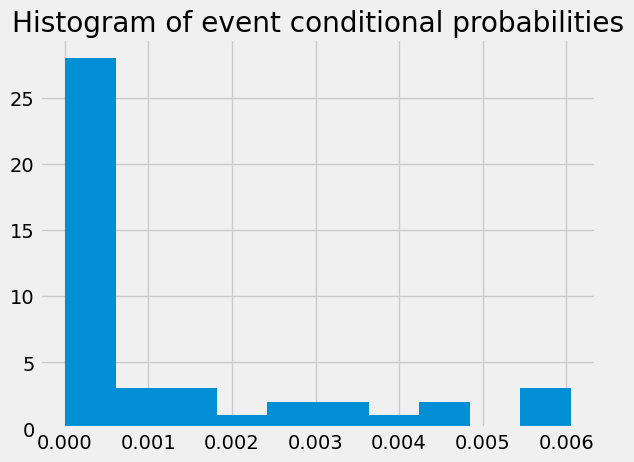

In [34]:
# ETAS declustered

fig,ax=plt.subplots()
plt.hist(aggregated_cp)
plt.title('Histogram of event conditional probabilities')
# plt.yscale('log')

#### The conditional probability will change quantitatively depending on the bin size. However, the same qualitative distribution remains, where there is a higher relative conditional probability during periods of large loading and unloading. 

#### Here, we calculate the Bayesian probability using two different bin sizes which are calculated via two methods:

##### a. Sturge's Rule
##### b. Freedman-Diaconis Rule


In [35]:
def plot_bayes_mascon(ax, earthquake_only, title, xlab, method, fs):
    plt.style.use('fivethirtyeight')
    
    bins = loadquakes.calculate_bin_sizes(LgE_list, method) 
    wid = np.mean(np.diff(bins))
    
    print(len(bins))
    print(len(aggregated_cp))
    
    ax.bar(bins[:-1], aggregated_cp, width=wid, align='edge')

    xl = ax.get_xlim()
    ax.set_xlim(xl[0], xl[1] - 4.4)
    ax.set_xlabel(xlab, fontsize=fs)
    ax.set_ylabel('Conditional probability', fontsize=fs)
    ax.set_title(title, fontsize=fs)
    ax.grid

46
45


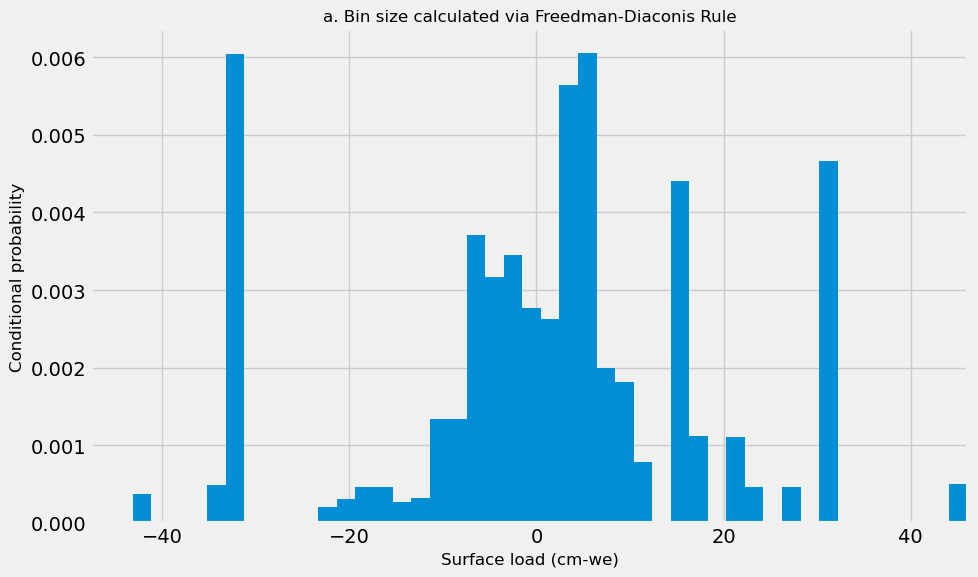

In [36]:
importlib.reload(loadquakes)
fig,ax = plt.subplots(figsize=(10,6))

plt.style.use('fivethirtyeight')

plot_bayes_mascon(ax, np.array(etas_declustered.dmass), 
                  "a. Bin size calculated via Freedman-Diaconis Rule", 
                  'Surface load (cm-we)', 
                  method='fd', fs=12)

fig.tight_layout()

### II. Full catalog

In [23]:
LgE_list, L_list, E_list, N_per_mascon = calculate_probabilities_by_mascon(ds['lwe_thickness'], catalog, mascon)

In [ ]:
bins, cp_list, normalized_cp_list = get_cp(LgE_list, L_list, E_list, 'fd')
cp_for_each_event = assign_cp(ds['lwe_thickness'], catalog, aggregated_cp)
catalog.loc[:, 'cp_by_mascon'] = cp_for_each_event

In [ ]:
# Full catalog

fig,ax=plt.subplots()
plt.hist(aggregated_cp)
plt.title('Histogram of event conditional probabilities')
# plt.yscale('log')

In [ ]:
importlib.reload(loadquakes)
fig,ax = plt.subplots(figsize=(10,6))

plt.style.use('fivethirtyeight')

plot_bayes_mascon(ax, np.array(catalog.dmass), 
                  "a. Bin size calculated via Freedman-Diaconis Rule", 
                  'Surface load (cm-we)', 
                  method='fd', fs=12)

fig.tight_layout()